# Chat BUT

## Preview-Result
___
___

### Chatting

In [154]:
sentence_generation('어제 헤어졌어 .')
print()

입력 : 어제 헤어졌어 .
출력 : 힘껏 울고 천천히 털어내길 천천히 털어내길 바랄게요 .



In [155]:
sentence_generation('너무 짜증나')
print()

입력 : 너무 짜증나
출력 : 짜증날 때는 기분 푸는 음악 주실거예요 . 사랑은 선택은 편으로 살은 간사집 마련의 나를 배려해야 목 사랑하세요 .



In [156]:
sentence_generation('그 여자...')
print()

입력 : 그 여자...
출력 : 조금만 더 버텨요 . 버텨요 .



In [157]:
sentence_generation('사랑 그놈')
print()

입력 : 사랑 그놈
출력 : 연애 사람이 좋습니다 .



In [158]:
sentence_generation('나 혼자만의 착각이었을까 ?')
print()

입력 : 나 혼자만의 착각이었을까 ?
출력 : 오늘도 평안했던 사랑해 , 여자사람친구 , 여자사람친구 , 여자사람친구 , 여자사람친구 , 여자사람친구 , 여자사람친구 하세요 .



### Preprocessing

In [ ]:
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # Put in spaces on both sides of punctuation
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # Filtering characters; only korean english punctuation
  sentence = re.sub(r"[^0-9가-힣a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence
print("슝=3")

In [159]:
# 표준정규분포표를 활용하여 X <= mean + 2 * std --> 정규분포에서 95% 영역 포함
MAX_LENGTH = int(mean+2*std)
print(MAX_LENGTH) # 29

np.round((df['len_A'] <= MAX_LENGTH).sum() / len(df) * 100, 2), np.round((df['len_Q'] <= MAX_LENGTH).sum() / len(df) * 100, 2)

(95.91, 97.71)

In [ ]:
# Tokenizer 생성
print(len(questions))
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

## Index
___


1.   Configuration
  - Font
2.   Module
3. Define Function
4. Data Download
5. Preprocessing
2. Modeling
2. Model Fitting
1. Generate Sentence

- 회고



### Configuration

#### Font
___

In [95]:
# this step prevents korean doesnt work
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

### Module
___

In [96]:
import os
import sys
import re
import pickle
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')

import tensorflow as tf

In [97]:
import tensorflow as tf
import tensorflow_datasets as tfds

### Define Function
___

In [98]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


In [99]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


In [100]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


In [101]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [102]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


In [103]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [104]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [105]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [106]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [107]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


In [108]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


In [109]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


In [110]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [111]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


### Data Download
___

In [112]:
!git clone https://github.com/songys/Chatbot_data.git

fatal: destination path 'Chatbot_data' already exists and is not an empty directory.


In [113]:
df = pd.read_csv("/content/Chatbot_data/ChatbotData.csv")
del df['label']
df.head()

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


In [114]:
# there is no NaN
# len(df) is 11823
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
dtypes: object(2)
memory usage: 184.9+ KB


### Preprocessing
___

In [115]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^0-9가-힣a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence
print("슝=3")

슝=3


In [116]:
print(df['Q'][0])
preprocess_sentence(df['Q'][0])

12시 땡!


'12시 땡 !'

In [117]:
df['edited_Q'] = df['Q'].apply(preprocess_sentence)
df['edited_Q']

0                         12시 땡 !
1                     1지망 학교 떨어졌어
2                    3박4일 놀러가고 싶다
3                 3박4일 정도 놀러가고 싶다
4                         ppl 심하네
                   ...           
11818             훔쳐보는 것도 눈치 보임 .
11819             훔쳐보는 것도 눈치 보임 .
11820                흑기사 해주는 짝남 .
11821    힘든 연애 좋은 연애라는게 무슨 차이일까 ?
11822                  힘들어서 결혼할까봐
Name: edited_Q, Length: 11823, dtype: object

In [118]:
df['edited_A'] = df['A'].apply(preprocess_sentence)
df['edited_A']

0                      하루가 또 가네요 .
1                       위로해 드립니다 .
2                     여행은 언제나 좋죠 .
3                     여행은 언제나 좋죠 .
4                      눈살이 찌푸려지죠 .
                   ...            
11818          티가 나니까 눈치가 보이는 거죠 !
11819               훔쳐보는 거 티나나봐요 .
11820                      설렜겠어요 .
11821    잘 헤어질 수 있는 사이 여부인 거 같아요 .
11822          도피성 결혼은 하지 않길 바라요 .
Name: edited_A, Length: 11823, dtype: object

In [119]:
questions, answers = [], []

df['edited_Q'].apply(lambda x: questions.append(x))
df['edited_A'].apply(lambda x: answers.append(x))
len(questions), len(answers)

(11823, 11823)

In [120]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
print(len(questions))
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

11823
슝=3 


In [121]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [122]:
VOCAB_SIZE = tokenizer.vocab_size *2

In [123]:
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5756, 610, 2486, 4158]
정수 인코딩 후의 21번째 답변 샘플: [2355, 7502, 7, 6266, 97, 1]


In [124]:
# to determine max_length of sentences
df['len_Q'] = df['edited_Q'].apply(lambda x:len(x))
df['len_A'] = df['edited_A'].apply(lambda x:len(x))
df.head()

,Q,A,edited_Q,edited_A,len_Q,len_A
0,12시 땡!,하루가 또 가네요.,12시 땡 !,하루가 또 가네요 .,7,11
1,1지망 학교 떨어졌어,위로해 드립니다.,1지망 학교 떨어졌어,위로해 드립니다 .,11,10
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,12,12
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,15,12
4,PPL 심하네,눈살이 찌푸려지죠.,ppl 심하네,눈살이 찌푸려지죠 .,7,11


In [125]:
df['len_Q'].describe()

count    11823.000000
mean        13.213736
std          6.410260
min          1.000000
25%          9.000000
50%         12.000000
75%         16.000000
max         57.000000
Name: len_Q, dtype: float64

In [126]:
df['len_A'].describe()

count    11823.000000
mean        16.035439
std          6.775018
min          1.000000
25%         11.000000
50%         15.000000
75%         19.000000
max         78.000000
Name: len_A, dtype: float64

In [127]:
mean = df['len_A'].mean()
std = df['len_A'].std()

In [128]:
MAX_LENGTH = int(mean+2*std)
MAX_LENGTH

29

In [129]:
np.round((df['len_A'] <= MAX_LENGTH).sum() / len(df) * 100, 2), np.round((df['len_Q'] <= MAX_LENGTH).sum() / len(df) * 100, 2)

(95.91, 97.71)

In [130]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  for (sentence1, sentence2) in zip(inputs, outputs):

    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
      sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='pre')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='pre')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [131]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 16324
필터링 후의 질문 샘플 개수: 11087
필터링 후의 답변 샘플 개수: 11087


In [132]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


### Modeling
___

In [133]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(      
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    5233152     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

Text(0.5, 0, 'Train Step')

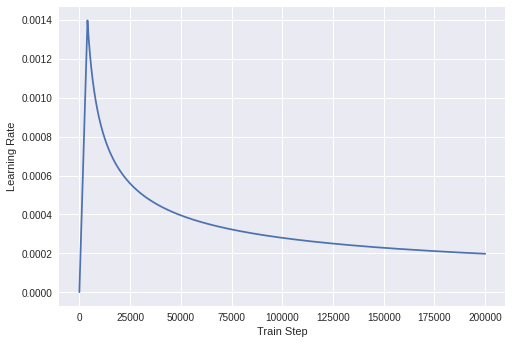

In [134]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Model Fitting
___

In [135]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [136]:
random_seed = 71

random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [137]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
174/174 [==============================] - 19s 72ms/step - loss: 2.4078 - accuracy: 0.0593
Epoch 2/50
174/174 [==============================] - 13s 72ms/step - loss: 1.8710 - accuracy: 0.1042
Epoch 3/50
174/174 [==============================] - 12s 71ms/step - loss: 1.3907 - accuracy: 0.1062
Epoch 4/50
174/174 [==============================] - 13s 72ms/step - loss: 1.2089 - accuracy: 0.1112
Epoch 5/50
174/174 [==============================] - 13s 72ms/step - loss: 1.1221 - accuracy: 0.1160
Epoch 6/50
174/174 [==============================] - 13s 72ms/step - loss: 1.0474 - accuracy: 0.1207
Epoch 7/50
174/174 [==============================] - 12s 71ms/step - loss: 0.9706 - accuracy: 0.1266
Epoch 8/50
174/174 [==============================] - 12s 72ms/step - loss: 0.8863 - accuracy: 0.1358
Epoch 9/50
174/174 [==============================] - 12s 71ms/step - loss: 0.7937 - accuracy: 0.1465
Epoch 10/50
174/174 [==============================] - 12s 71ms/step - loss: 0.696

### Result
___

In [148]:
sentence_generation('어제 헤어졌어 .')
print()

입력 : 어제 헤어졌어 .
출력 : 힘껏 울고 천천히 털어내길 천천히 털어내길 바랄게요 .



In [150]:
sentence_generation('너무 짜증나')
print()

입력 : 너무 짜증나
출력 : 짜증날 때는 기분 푸는 음악 주실거예요 . 사랑은 선택은 편으로 살은 간사집 마련의 나를 배려해야 목 사랑하세요 .



In [149]:
sentence_generation('그 여자...')
print()

입력 : 그 여자...
출력 : 조금만 더 버텨요 . 버텨요 .



In [152]:
sentence_generation('사랑 그놈')
print()

입력 : 사랑 그놈
출력 : 연애 사람이 좋습니다 .



# 회고

기존의 모델에 DataFrame에 맞도록 적절히 수정하고  

epoch를 늘렸더니 적절한 결과가 나왔다.  

하지만 데이터에 적합하지 않은 일상 대화에서는 상당히 술기운이 도는 답변을 들었다.  

트렌스포머에 대한 논문 분석을 하고 직접 구현할 수 있도록 하는 것이 목표이며  

천천히 뜯어가며 포스팅할 예정이다.  

# Reference

https://helloyjam.github.io/tensorflow/buffer-size-in-shuffle/

_dataset.shuffle(buffer_size) 의 중요성_